In [1]:
# Import required packages
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from torchhd import HRRTensor

from tqdm import tqdm

In [2]:
from torch_geometric.datasets import ZINC
from src.datasets import AddNodeDegree

dataset = ZINC(root="/Users/arvandkaveh/Projects/kit/graph_hdc/datasets/test/zinc_subset_with_degree", pre_transform=AddNodeDegree())

In [3]:
from torch_geometric import loader

batch_size = 32
dataloader = loader.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [8]:
from src.encoding.types import VSAModel
from src.encoding.configs_and_constants import SupportedDataset
import torch

vsa = "HRR"
hv_dim = 8*8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42

ds = SupportedDataset.ZINC_NODE_DEGREE_COMB
ds.default_cfg.vsa = VSAModel(vsa)
ds.default_cfg.hv_dim = hv_dim
ds.default_cfg.device = device
ds.default_cfg.seed = seed
# Disable edge and graph features
ds.default_cfg.edge_feature_configs = {}
ds.default_cfg.graph_feature_configs = {}

In [9]:
from src.encoding.graph_encoders import HyperNet

dataloader_iter = iter(dataloader)
hypernet = HyperNet(config=ds.default_cfg, hidden_dim=ds.default_cfg.hv_dim, depth=3)
def get_my_hypervectors():
    n = next(dataloader_iter)
    res = hypernet.forward(data=n)
    x = torch.stack([res["node_terms"], res["edge_terms"], res["graph_embedding"]], dim=1)
    return x

In [10]:
# Set up model

# Define flows
K = 16
torch.manual_seed(seed)

latent_size = 3 * hv_dim
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribuiton
q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows)
nfm = nfm.to(device)

 50%|█████     | 501/1000 [00:53<00:55,  8.99it/s]

iter 500, loss 1403802.5000


100%|██████████| 1000/1000 [01:46<00:00,  9.37it/s]

iter 1000, loss 899040.7500


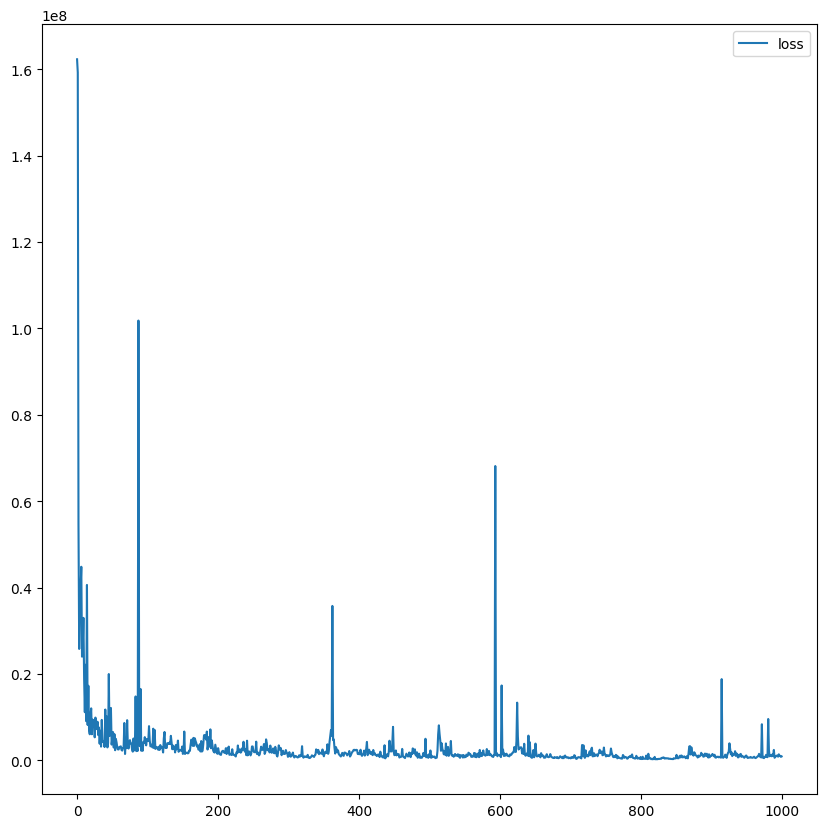

In [11]:
# Train model
max_iter = 1000
num_samples = 2 ** 9
show_iter = 500
lr = 1e-3
wd = 1e-5


loss_hist = np.array([])

nfm.train()
optimizer = torch.optim.Adam(nfm.parameters(), lr=lr, weight_decay=wd)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # get a batch of [batch_size, 3, D]
    x = get_my_hypervectors()      # user-supplied func
    x = x.to(device).view(batch_size, -1)    # flatten to [batch_size,3*D]

    # Compute loss
    loss = nfm.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        print("iter %d, loss %.4f" % (it + 1, loss))

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [12]:
# ---- Sampling example ----
n_samples = 10
s, l = nfm.sample(n_samples)
z = s.to("cpu")# [n_samples, 3*D]
z = z.view(n_samples, 3, hv_dim)             # back to [n_samples, 3, D]

In [13]:
import torch
from torchhd import HRRTensor

node_terms_s, edge_terms_s, graph_embeddings_s = z.unbind(dim=1)

## Cast to HRRTensor
node_terms_s_hrr = node_terms_s.as_subclass(HRRTensor)
edge_terms_s_hrr = edge_terms_s.as_subclass(HRRTensor)
graph_embeddings_s_hrr = graph_embeddings_s.as_subclass(HRRTensor)

In [ ]:
for b in range(n_samples):

    data_dec, node_counter_dec, edge_counter_dec = hypernet.reconstruct(
    graph_hv=graph_embeddings_s_hrr[b],
    node_terms=node_terms_s_hrr[b],
    edge_terms=edge_terms_s_hrr[b],
    learning_rate=0.1,
    batch_size=10,
    low=0,
    high=1,
    alpha=0.1,
    lambda_l1=0.01,
    use_node_degree=True # Alpha = 0, zeroes the node_degree loss
    )
    print(f"{data_dec=}")
    print(f"{node_counter_dec=}")
    print(f"{edge_counter_dec=}")

torch.Size([8100])
